# Evaluation Metrics

In [1]:
from itertools import chain
import random
import numpy as np
import pandas as pd
from typing import List, Dict
from scipy.stats import ks_2samp
from scipy.stats import spearmanr, mstats
from statsmodels.formula.api import mnlogit, ols, glm
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from synthesized.testing.evaluation import Evaluation
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm




/Users/simonhkswan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/simonhkswan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


## Metrics


### continuous and continuous
- continuous_correlation
- continuous_rsquared
- rank_correlation
- rank_rsquared

In [2]:
# --- Association between continuous and continuous
def continuous_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]


def continuous_rsquared(x, y):
    return continuous_correlation(x, y)**2


def ordered_correlation(x, y):
    return spearmanr(x, y).correlation


def ordered_rsquared(x, y):
    return ordered_correlation(x, y)**2



### categorical and categorical
- categorical_logistic_rsquared
- cramers_v
- nominal_association
- ordinal_association


In [3]:
# --- Association between categorical and categorical
def categorical_logistic_rsquared(x, y):
    temp_df = pd.DataFrame({"x": x, "y": y})
    model = mnlogit("y ~ C(x)", data=temp_df).fit(method="cg", disp=0)
    return model.prsquared

def contingency_table(x, y):
    temp_df = pd.DataFrame({"x": x, "y": y})
    table = sm.stats.Table.from_data(temp_df)
    return table

def cramers_v(x, y):
    table = contingency_table(x, y)
    expected = table.fittedvalues.to_numpy()
    real = table.table
    r, c = real.shape
    N = np.sum(real)
    
    v = np.sum((real-expected)**2/(expected*N*min(r-1, c-1)))**0.5
    
    return v

def nominal_association_pvalue(x, y):
    return contingency_table(x, y).test_nominal_association().pvalue

def ordinal_association_pvalue(x, y):
    return contingency_table(x, y).test_ordinal_association().pvalue

def nominal_association_value(x, y):
    return contingency_table(x, y).test_nominal_association().statistic

def ordinal_association_value(x, y):
    return contingency_table(x, y).test_ordinal_association().statistic


def chi_sq_components(x, y):
    table = contingency_table(x, y)
    expected = table.fittedvalues.to_numpy()
    real = table.table
    r, c = real.shape
    N = np.sum(n)
    
    vv = (real-expected)**2/(expected)
    
    return vv

def categorical_association_movements(x, y, j, k):
    real = contingency_table(x, y).table
    expected = contingency_table(j, k).table
    r, c = real.shape
    N = np.sum(n)
    
    vv = (real-expected)**2/(expected*N)
    
    return vv

def chi_sq(x, y, j, k):
    real = contingency_table(x, y).table
    expected = contingency_table(j, k).table
    r, c = real.shape
    N = np.sum(n)
    
    v = np.sum((real-expected)**2/(expected*N))
    
    return v
    

### continuous and categorical
- continuous_logistic_rsquared


In [4]:
# --- Association between continuous and categorical
def continuous_logistic_rsquared(x, y):
    temp_df = pd.DataFrame({"x": x, "y": y})
    model = mnlogit("y ~ x", data=temp_df).fit(method="cg", disp=0)
    return model.prsquared



### categorical and continuous
- anova_rsquared

In [5]:
# --- Association between categorical and continuous
def anova_rsquared(x, y):
    temp_df = pd.DataFrame({"x": x, "y": y})
    model = ols("y ~ C(x)", data=temp_df).fit(method="cg", disp=0)
    return model.rsquared

## Categorical Plotting Functions

In [6]:
def category_plot(x, y, ax=None, normalize=None, xcats=None, ycats=None):
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
    
    xcats = xcats or np.sort(list(set(x))).tolist()
    ycats = ycats or np.sort(list(set(y))).tolist()
    
    fmt = '0.0f'
    norm = LogNorm()
    if normalize == 'conditional':
        norm=None
        table = contingency_table(x, y)
        expected = table.fittedvalues.to_numpy()+1.0
        real = table.table
        
        values = ((real-expected)/expected).flatten()
        records = [(xcats[n//len(ycats)], ycats[n%len(ycats)], v) for n, v in enumerate(values)]

        x, y, counts = zip(*records)
        fmt = '.03f'
        vmax = 2.0
        df = pd.DataFrame({'x': x, 'y': y, 'counts':counts})
        df_pivot = df.pivot('x', 'y', 'counts')
        
    else:
        temp_df = pd.DataFrame({"x": x, "y": y})
        df = temp_df.groupby(['x', 'y']).size().reset_index(name='counts')
        vmax = np.sum(df['counts'])/min(len(xcats),len(ycats))
        if normalize == 'global':
            df['counts'] = df['counts']/np.sum(df['counts'])
            fmt='.03f'
            vmax = 1.0/min(len(xcats),len(ycats))
        df_pivot = df.pivot('x', 'y', 'counts')
        
    
    sns.heatmap(data=df_pivot, annot=True, ax=ax, square=True, fmt=fmt,
                xticklabels=ycats,
                yticklabels=xcats, cbar=False, center=0.0, norm=norm, vmax=vmax,
                cmap='BrBG')
    # ax.invert_yaxis()
    ax.set_ylim(len(xcats)+0.5, -0.5)
    ax.xaxis.set_ticks_position('top')
    return df


def continuous_category_plot(x, y, ax=None, palette=None):
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
    
    norm = LogNorm()
    

    temp_df = pd.DataFrame({"x": x, "y": y})
    df = temp_df.groupby(['x', 'y']).size().reset_index(name='count')
    df['size'] = np.log(df['count']+1)*20
    
    sns.scatterplot(data=df, x='x', y='y', size='size', hue='count', hue_norm=norm,
                    ax=ax, alpha=0.85, legend=False, palette=palette)
    
    
    m = continuous_correlation(x, y)
    c = np.mean(a)-m*np.mean(b)

    ax.plot([i for i in range(100)],[m*i + c for i in range(100)], linestyle=':', color=[0.7,0.1,0.3])
    
    return df

def category_plots(x, y, u, v, normalize=False):
    xcats = np.sort(list(set(x))).tolist()
    ycats = np.sort(list(set(y))).tolist()
    fig, axes = plt.subplots(1,3,figsize=(len(xcats)*2+6,len(ycats)+4))

    d1 = category_plot(x, y, ax=axes[0], normalize=normalize, xcats=xcats, ycats=ycats)
    d2 = category_plot(u, v, ax=axes[1], normalize=normalize, xcats=xcats, ycats=ycats)
    
    c1 = {(d1['x'][n], d1['y'][n]): d1['counts'][n] for n in range(len(d1))}
    c2 = {(d2['x'][n], d2['y'][n]): d2['counts'][n] for n in range(len(d2))}
    
    c3 = {k: np.abs(c1.get(k, 0.0)-c2.get(k, 0.0)) for k in set(chain(c1.keys(),c2.keys()))}
    
    
    
    xy, counts = zip(*c3.items())
    x, y = zip(*xy)
    fmt = '.03f' if normalize else '0.0f'
    vmax = 2.0 if normalize == 'conditional' else 1.0/min(len(xcats),len(ycats)) if normalize == 'global' else np.sum(counts)/min(len(xcats),len(ycats))
    
    df = pd.DataFrame({'x': x, 'y': y, 'counts': counts})
    df_pivot = df.pivot('x', 'y', 'counts')
    sns.heatmap(data=df_pivot, annot=True, ax=axes[2], square=True, fmt=fmt,
                xticklabels=ycats,
                yticklabels=xcats, cbar=False, center=0.0, vmax=vmax,
                cmap='RdBu_r')
    # axes[2].invert_yaxis()
    axes[2].set_ylim(len(xcats)+0.5, -0.5)
    axes[2].xaxis.set_ticks_position('top')

## Categorical Dataset Generation Functions




In [7]:
letters = 'abcdefghijklmnopqrstuvwxyz'

def random_categories(num_classes, rows, name='1'):
    classes = [l+name for l in letters]
    return np.random.choice(classes[:num_classes], rows)


def distributed_categories(probabilities, rows, name='1'):
    new_records = []
    for _ in range(rows):
        roll = random.random()
        for i, val in enumerate(np.cumsum(probabilities)):
            if roll < val:
                new_records.append((letters[i]+name,))
                break
    
    return new_records

    
def add_linked_categories(records, correlations, name='1'):
    num_cats = len(correlations)
    
    cat_map = {letters[n]: np.cumsum(correlations[n]) for n in range(num_cats)}
    new_records = []
    for record in records:
        roll = random.random()
        corr = cat_map[record[-1][:1]]
        for i, val in enumerate(corr):
            if roll < val:
                new_records.append(record+(letters[i]+name,))
                break
    
    return new_records
    

## Comparing Two Categorical Variables (Num Categories - V1: 4, V2: 2)

logistic r^2: 0.000111, 0.000312
logistic r: 0.010541, 0.017676
cramer's v: 0.012411, 0.020810
nominal association value: 1.540325, 4.330683
nominal association pvalue: 0.672995, 0.227899
ordinal association value: 7616.000000, 7539.000000
ordinal association pvalue: 0.431457, 0.335750


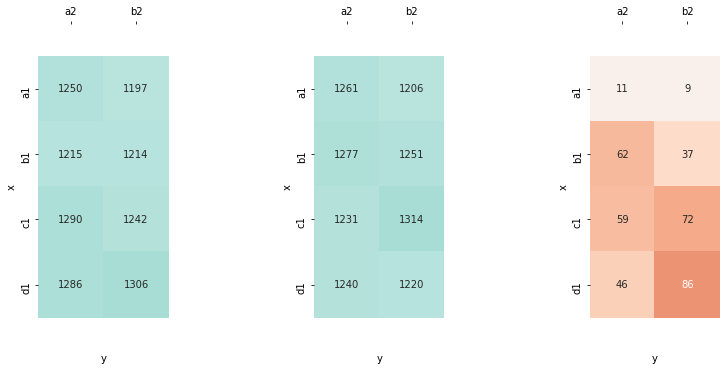

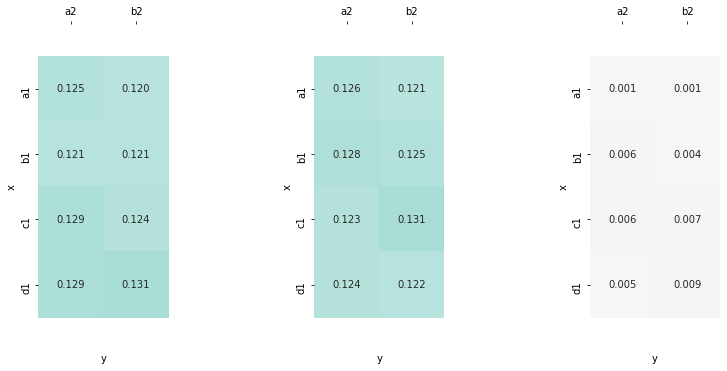

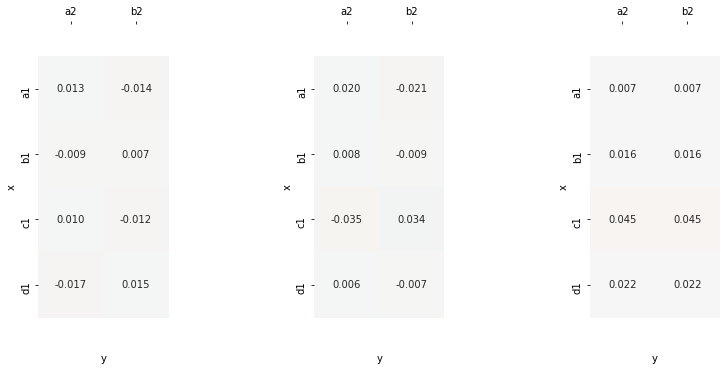

In [8]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.5, 0.5],
     [0.5, 0.5]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.5, 0.5],
     [0.5, 0.5]], name='2')

c, d = zip(*records2)


print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.000159, 0.000092
logistic r: 0.012621, 0.009570
cramer's v: 0.014859, 0.011267
nominal association value: 2.207912, 1.269442
nominal association pvalue: 0.530392, 0.736402
ordinal association value: 7496.000000, 6665.000000
ordinal association pvalue: 0.515060, 0.613630


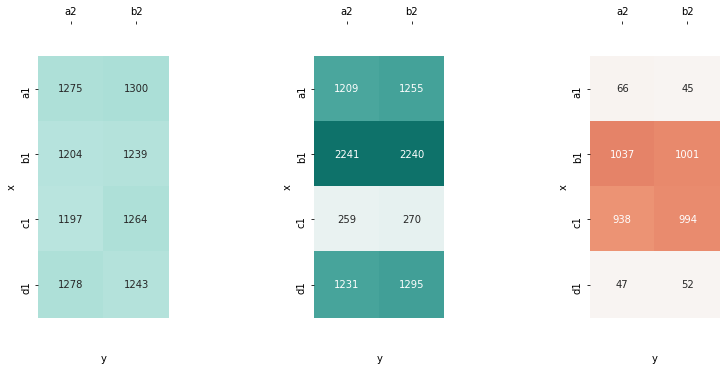

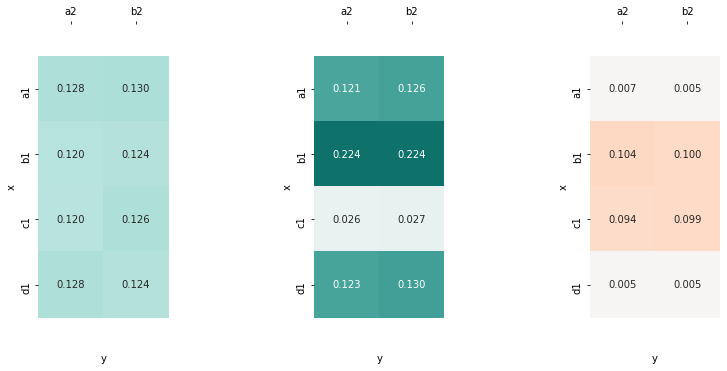

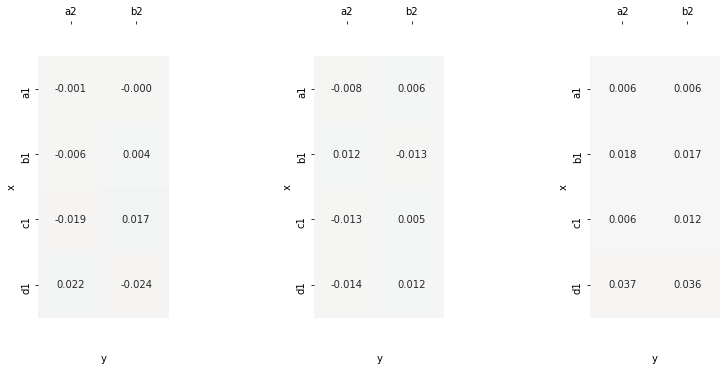

In [9]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.5, 0.5],
     [0.5, 0.5]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.45, 0.05, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.5, 0.5],
     [0.5, 0.5]], name='2')

c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.000288, 0.019373
logistic r: 0.016967, 0.139188
cramer's v: 0.019976, 0.161651
nominal association value: 3.990402, 261.311743
nominal association pvalue: 0.262502, 0.000000
ordinal association value: 7361.000000, 8360.000000
ordinal association pvalue: 0.480277, 0.000009


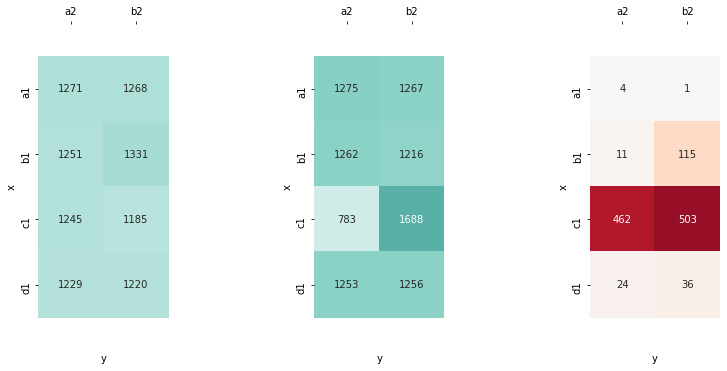

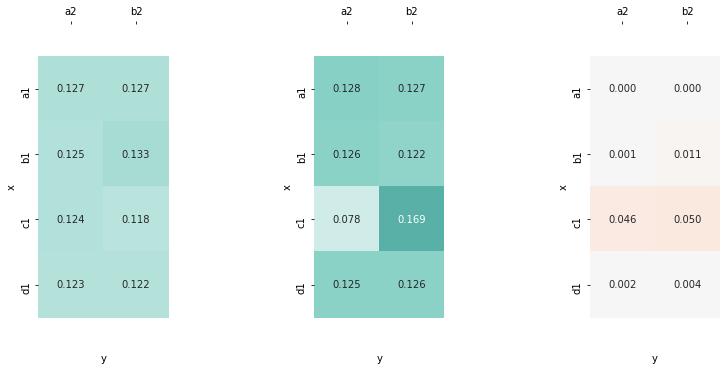

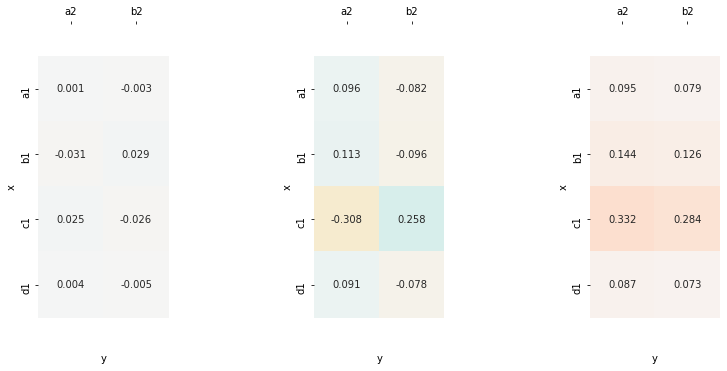

In [10]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.5, 0.5],
     [0.5, 0.5]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.5, 0.5],
     [0.3, 0.7],
     [0.5, 0.5]], name='2')

c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.190403, 0.156272
logistic r: 0.436352, 0.395313
cramer's v: 0.489069, 0.440006
nominal association value: 2391.889179, 1936.049626
nominal association pvalue: 0.000000, 0.000000
ordinal association value: 10061.000000, 8914.000000
ordinal association pvalue: 0.184720, 0.000000


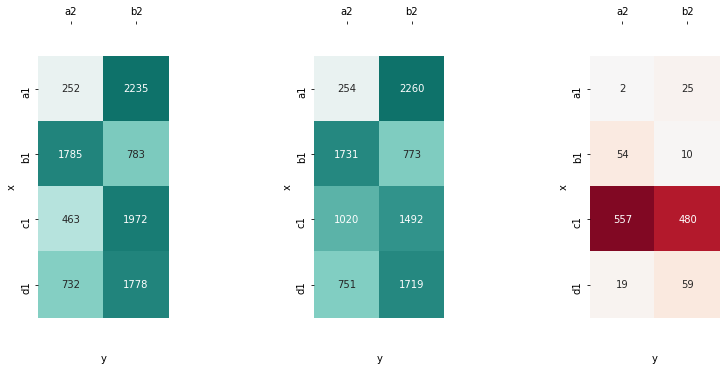

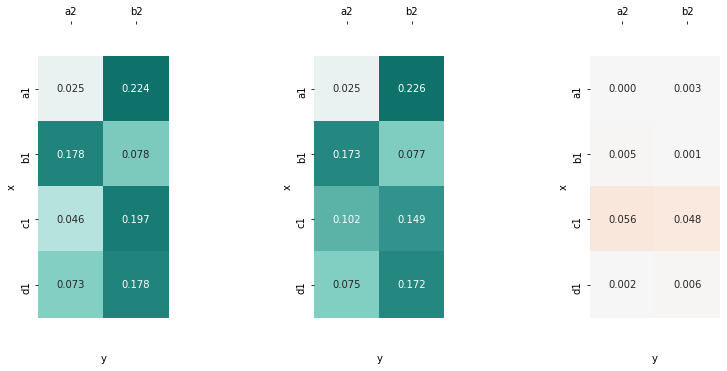

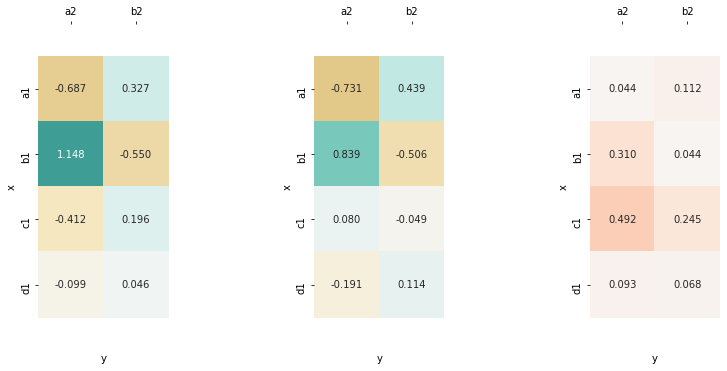

In [11]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.1, 0.9], 
     [0.7, 0.3],
     [0.2, 0.8],
     [0.3, 0.7]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.1, 0.9], 
     [0.7, 0.3],
     [0.4, 0.6],
     [0.3, 0.7]], name='2')

c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.289233, 0.292320
logistic r: 0.537804, 0.540666
cramer's v: 0.594060, 0.596745
nominal association value: 0.352908, 0.356105
nominal association pvalue: 0.000000, 0.000000
ordinal association value: 0.995490, 0.854530
ordinal association pvalue: 0.000000, 0.000000


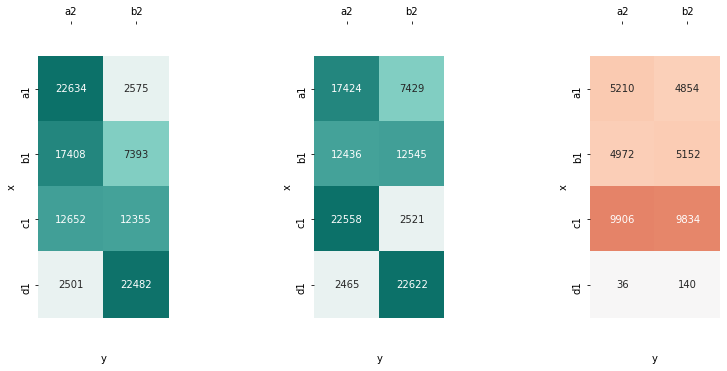

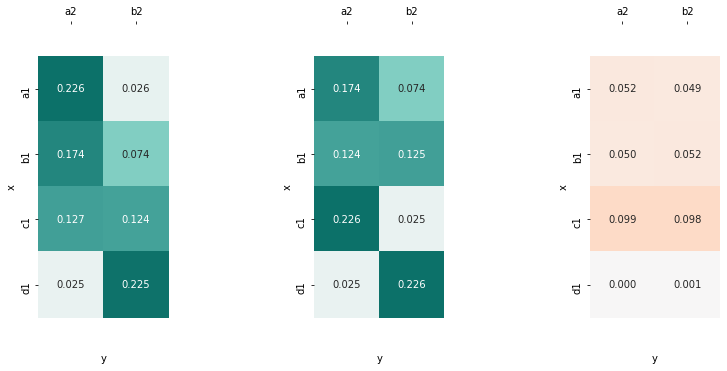

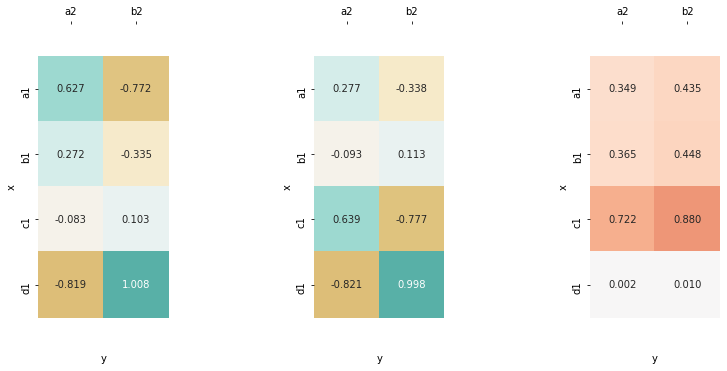

In [12]:
N = 100000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.9, 0.1], 
     [0.7, 0.3],
     [0.5, 0.5],
     [0.1, 0.9]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([1./4,]*4, N, name='1'), 
    [
     [0.7, 0.3],
     [0.5, 0.5],
     [0.9, 0.1], 
     [0.1, 0.9]], name='2')

c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b)/N:.6f}, {nominal_association_value(c, d)/N:.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b)/N:.6f}, {ordinal_association_value(c, d)/N:.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.284548, 0.281813
logistic r: 0.533430, 0.530861
cramer's v: 0.588671, 0.588361
nominal association value: 3465.330930, 3461.687291
nominal association pvalue: 0.000000, 0.000000
ordinal association value: 9770.000000, 8115.000000
ordinal association pvalue: 0.000000, 0.000000


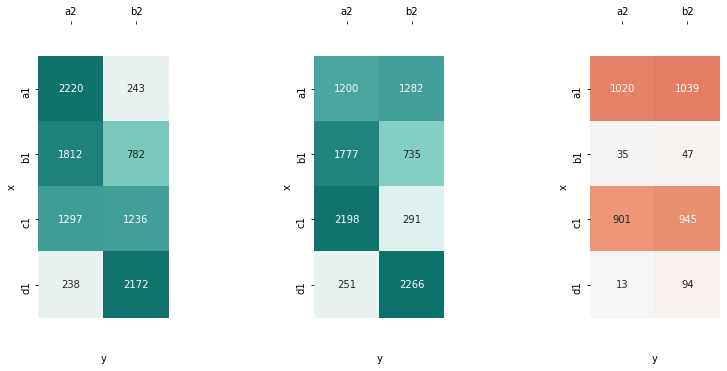

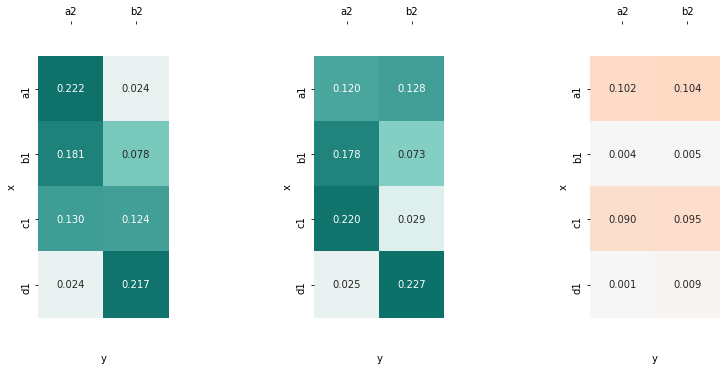

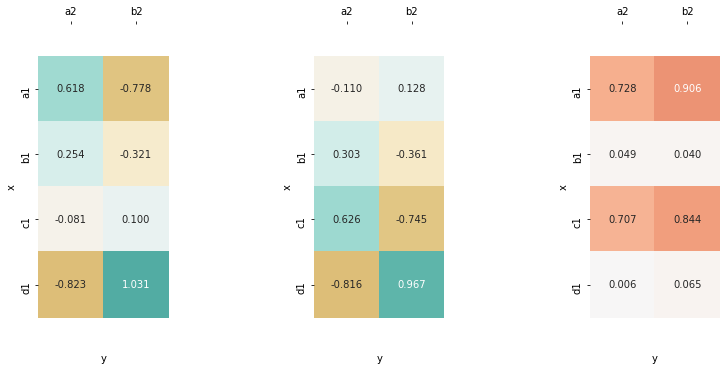

In [13]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.9, 0.1], 
     [0.7, 0.3],
     [0.5, 0.5],
     [0.1, 0.9]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.5, 0.5], 
     [0.7, 0.3],
     [0.9, 0.1],
     [0.1, 0.9]], name='2')

c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

logistic r^2: 0.999970, 0.999990
logistic r: 0.999985, 0.999995
cramer's v: 0.999471, 0.999468
nominal association value: 9991.419585, 9991.363767
nominal association pvalue: 0.000000, 0.000000
ordinal association value: 14974.000000, 12589.500000
ordinal association pvalue: 0.000000, 0.000000


/Users/simonhkswan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


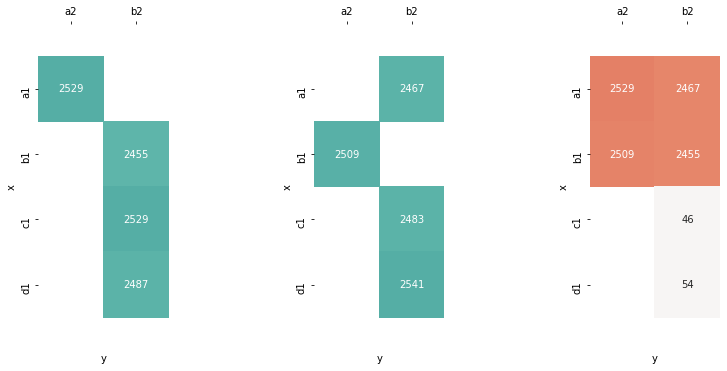

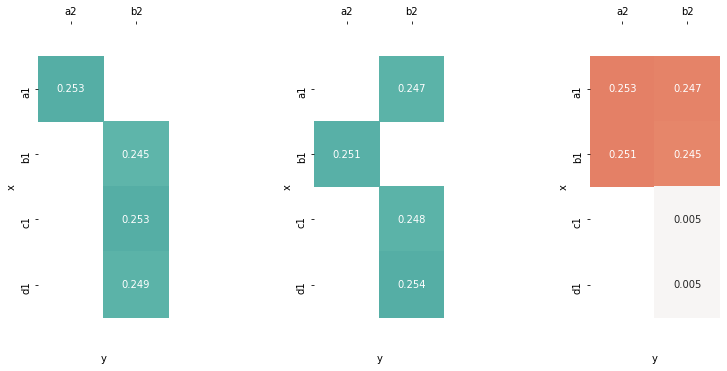

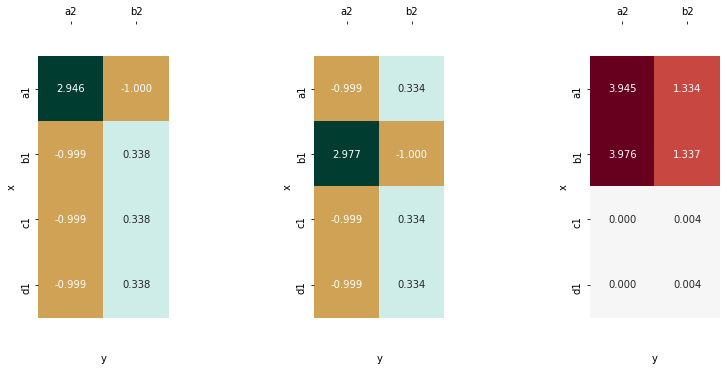

In [14]:
N = 10000
records = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[1.0, 0.0], 
     [0.0, 1.0],
     [0.0, 1.0],
     [0.0, 1.0]], name='2')

a, b = zip(*records)

records2 = add_linked_categories(
    distributed_categories([0.25, 0.25, 0.25, 0.25], N, name='1'), 
    [[0.0, 1.0], 
     [1.0, 0.0],
     [0.0, 1.0],
     [0.0, 1.0]], name='2')


c, d = zip(*records2)

print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

In [15]:
# -- training functions
from sklearn.model_selection import train_test_split
from synthesized import HighDimSynthesizer
from synthesized.testing.evaluation import Evaluation
data = pd.read_csv('/Users/simonhkswan/PycharmProjects/synthesized/data/credit.csv')
train, test = train_test_split(data, test_size=0.2, random_state=0)



def train_and_synthesize(data: pd.DataFrame, train: pd.DataFrame, test: pd.DataFrame):
    synthesizer = HighDimSynthesizer(df=data)
    with HighDimSynthesizer(df=data) as synthesizer:
        synthesizer.learn(df_train=train, num_iterations=2500)
        synthesized_data = synthesizer.synthesize(num_rows=len(test))
    
    
    return synthesized_data

In [16]:
synth_data = train_and_synthesize(data=data, train=train, test=test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
test.columns


Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [18]:
a, b = test['NumberOfTime30-59DaysPastDueNotWorse'], test['NumberOfTimes90DaysLate']
c, d = synth_data['NumberOfTime30-59DaysPastDueNotWorse'], synth_data['NumberOfTimes90DaysLate']

cramer's v: 0.292941, 0.402622
nominal association value: 30965.328633, 24320.159102
nominal association pvalue: 0.000000, 0.000000
ordinal association value: 16823.500000, 4823.500000
ordinal association pvalue: 0.000000, 0.000000


/Users/simonhkswan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


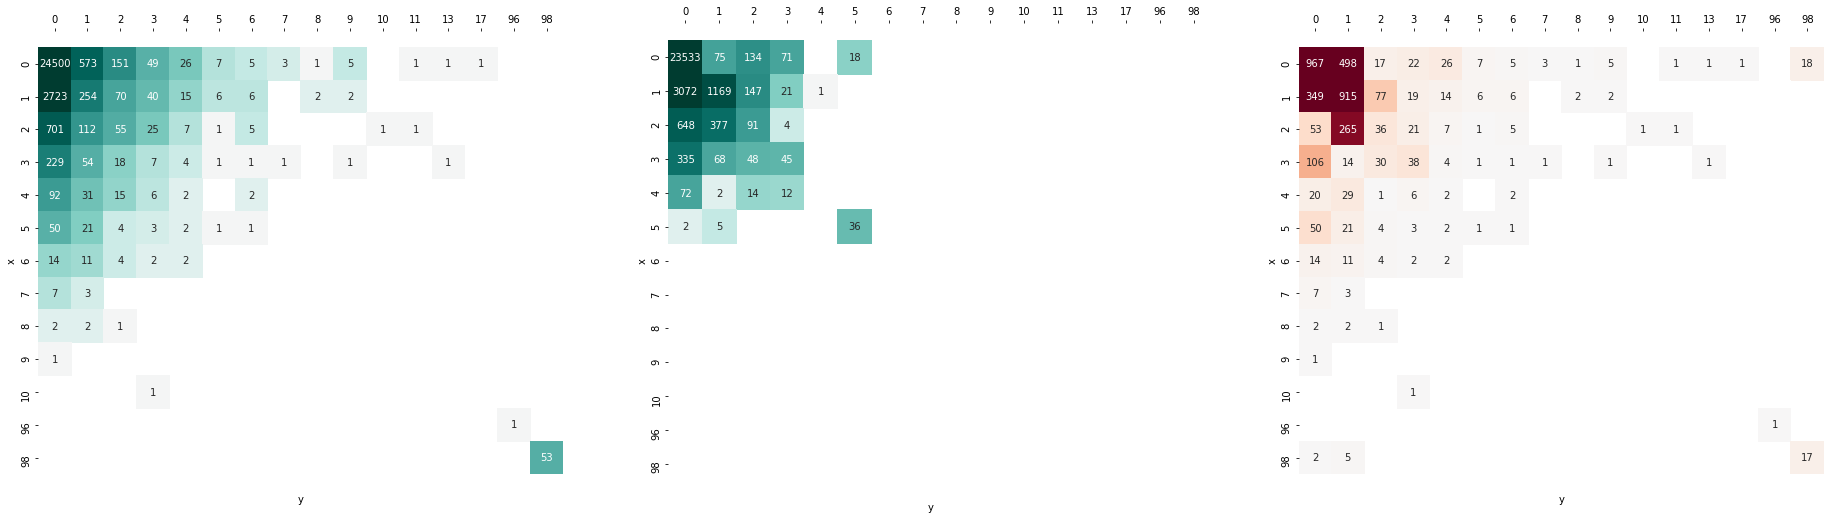

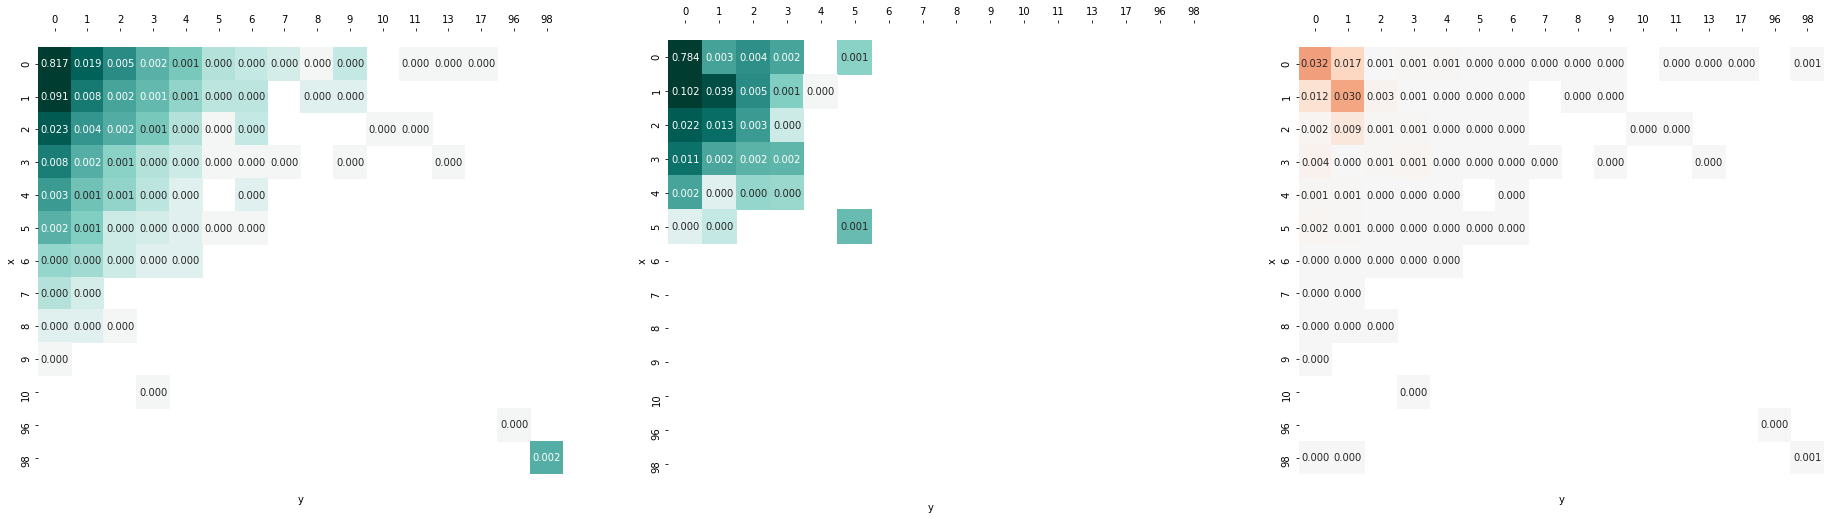

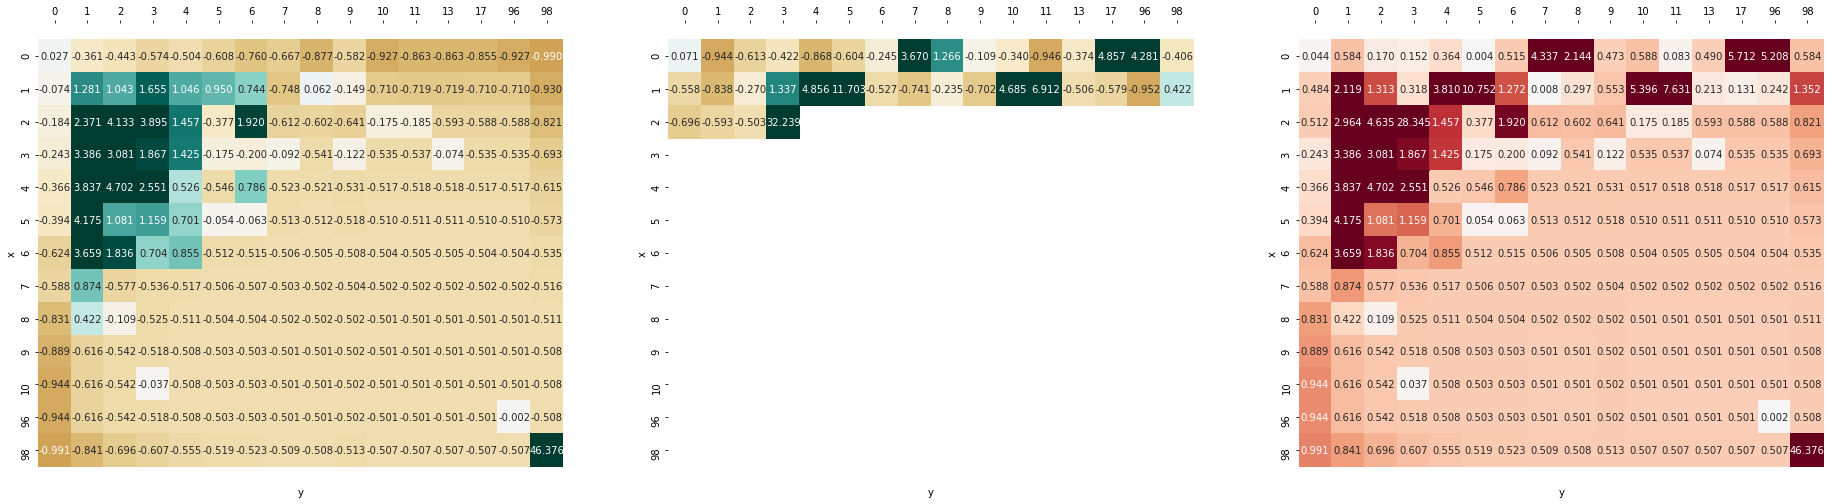

In [19]:
# print(f"logistic r^2: {categorical_logistic_rsquared(a, b):.6f}, {categorical_logistic_rsquared(c, d):.6f}")
# print(f"logistic r: {categorical_logistic_rsquared(a, b)**0.5:.6f}, {categorical_logistic_rsquared(c, d)**0.5:.6f}")
print(f"cramer's v: {cramers_v(a, b):.6f}, {cramers_v(c, d):.6f}")
print(f"nominal association value: {nominal_association_value(a ,b):.6f}, {nominal_association_value(c, d):.6f}")
print(f"nominal association pvalue: {nominal_association_pvalue(a ,b):.6f}, {nominal_association_pvalue(c, d):.6f}")
print(f"ordinal association value: {ordinal_association_value(a ,b):.6f}, {ordinal_association_value(c, d):.6f}")
print(f"ordinal association pvalue: {ordinal_association_pvalue(a ,b):.6f}, {ordinal_association_pvalue(c, d):.6f}")
category_plots(a,b,c,d)
category_plots(a,b,c,d, normalize='global')
category_plots(a,b,c,d, normalize='conditional')

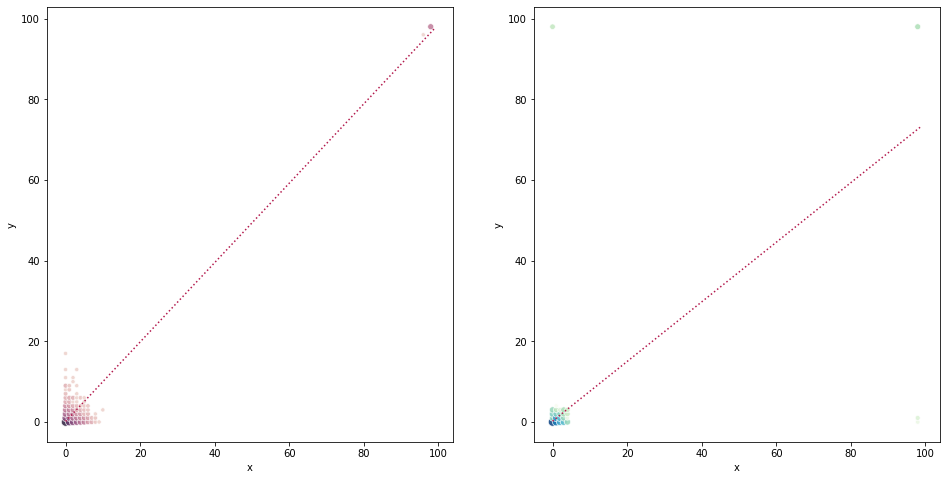

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
df = continuous_category_plot(a, b, ax=axes[0])
df2 = continuous_category_plot(c, d, ax=axes[1], palette='GnBu')